In [1]:
pip install python-bidi

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade mlxtend

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os 
os.getcwd()

'C:\\Users\\admin.nasim.FLCLAN'

In [4]:
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
#import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib
import pyodbc

In [5]:
conn_str = (     r'driver={SQL Server};' 
            r'server=azdwdflc01;'   
            r'database=ODS;'   
            r'trusted_connection=yes;'    ) 
cnxn = pyodbc.connect(conn_str) 
cursor = cnxn.cursor()

In [6]:
query = '''
        SELECT * 
            FROM dbo.TEMP_MarginLines
            WHERE InvoiceDate > '2024-01-01'
        ;
            '''

df= pd.read_sql(query, cnxn)
#df.head(2)

C:\Users\local_admin.nasim.FLCLAN1\Temp\ipykernel_31052\281780202.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df= pd.read_sql(query, cnxn)


In [7]:
# Create a transaction matrix
basket = pd.pivot_table(
    data=df,
    values='Qty',
    index='CustomerID',
    columns='ProductGroup',
    aggfunc='sum',
    fill_value=0
)

In [8]:
# Convert values to binary data (presence or absence of product)
basket = basket > 0

In [9]:
# Reduce sensitivity: run FP-Growth algorithm with lower min_support
frequent_itemsets = fpgrowth(basket, min_support=0.05, use_colnames=True)

In [10]:
frequent_itemsets

,support,itemsets
0,0.470603,(Hydraulic Hose Assemblies)
1,0.392073,(Adaptors)
2,0.192460,(Other Products)
3,0.439931,(Accessories)
4,0.243894,(Other Services)
...,...,...
354,0.051764,"(Hydraulic Hose Assemblies, Water cleaning & b..."
355,0.057027,"(Adaptors, Water cleaning & blasting)"
356,0.054025,"(Accessories, Water cleaning & blasting)"
357,0.050654,"(Hydraulic Fittings & Ferrules, Water cleaning..."


### Extract association rules with a lower minimum confidence threshold

In [11]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3, num_itemsets=len(frequent_itemsets))
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Adaptors),(Hydraulic Hose Assemblies),0.392073,0.470603,0.246896,0.629719,1.338112,1.0,0.062385,1.429717,0.415639,0.400948,0.300561,0.577178
1,(Hydraulic Hose Assemblies),(Adaptors),0.470603,0.392073,0.246896,0.524637,1.338112,1.0,0.062385,1.278870,0.477294,0.400948,0.218060,0.577178
2,(Accessories),(Adaptors),0.439931,0.392073,0.282419,0.641963,1.637355,1.0,0.109934,1.697943,0.695019,0.513877,0.411052,0.681143
3,(Adaptors),(Accessories),0.392073,0.439931,0.282419,0.720323,1.637355,1.0,0.109934,2.002557,0.640305,0.513877,0.500638,0.681143
4,"(Accessories, Adaptors)",(Hydraulic Hose Assemblies),0.282419,0.470603,0.196941,0.697336,1.481793,1.0,0.064034,1.749124,0.453108,0.354159,0.428285,0.557911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4382,(Water cleaning & blasting),(Hydraulic Hose Assemblies),0.068292,0.470603,0.051764,0.757977,1.610652,1.0,0.019625,2.187385,0.406923,0.106263,0.542833,0.433986
4383,(Water cleaning & blasting),(Adaptors),0.068292,0.392073,0.057027,0.835039,2.129805,1.0,0.030251,3.685280,0.569356,0.141386,0.728650,0.490244
4384,(Water cleaning & blasting),(Accessories),0.068292,0.439931,0.054025,0.791090,1.798213,1.0,0.023981,2.680907,0.476429,0.118946,0.626992,0.456947
4385,(Water cleaning & blasting),(Hydraulic Fittings & Ferrules),0.068292,0.188512,0.050654,0.741722,3.934604,1.0,0.037780,3.141913,0.800514,0.245712,0.681723,0.505212


In [12]:
# Save the rules to an Excel file
rules.to_excel('association_rules.xlsx', index=False)


In [13]:
# Review the association rules
if rules.empty:
    print("No association rules were found")
else:
    print("Association Rules: ")
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Association Rules: 
                      antecedents                      consequents   support  \
0                      (Adaptors)      (Hydraulic Hose Assemblies)  0.246896   
1     (Hydraulic Hose Assemblies)                       (Adaptors)  0.246896   
2                   (Accessories)                       (Adaptors)  0.282419   
3                      (Adaptors)                    (Accessories)  0.282419   
4         (Accessories, Adaptors)      (Hydraulic Hose Assemblies)  0.196941   
...                           ...                              ...       ...   
4382  (Water cleaning & blasting)      (Hydraulic Hose Assemblies)  0.051764   
4383  (Water cleaning & blasting)                       (Adaptors)  0.057027   
4384  (Water cleaning & blasting)                    (Accessories)  0.054025   
4385  (Water cleaning & blasting)  (Hydraulic Fittings & Ferrules)  0.050654   
4386  (Water cleaning & blasting)             (Bite Ring Fittings)  0.050654   

      confidence   

In [14]:
### Save the rules to an Excel file
#output_file = f"{file_path}\\AssociationRules_LowSensitivity.xlsx"
#rules.to_excel(output_file, index=False)
#print(f"قوانین انجمنی در فایل {output_file} ذخیره شدند.")

#### Visualization of Support for Frequent Itemsets

In [15]:
# Visualization of Support for Frequent Itemsets
###frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join([reshape_persian(i) for i in list(x)]))
#frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join([i for i in list(x)]))
#plt.figure(figsize=(10, 6))
#sns.barplot(
#    data=frequent_itemsets,
#    x='support',
#    y='itemsets',
#    color='skyblue'
#)
#plt.title('Support for recurring collections', fontsize=14)
#plt.xlabel('Support', fontsize=12)
#plt.ylabel('Collection of items', fontsize=12)
#plt.tight_layout()
#plt.show()


C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


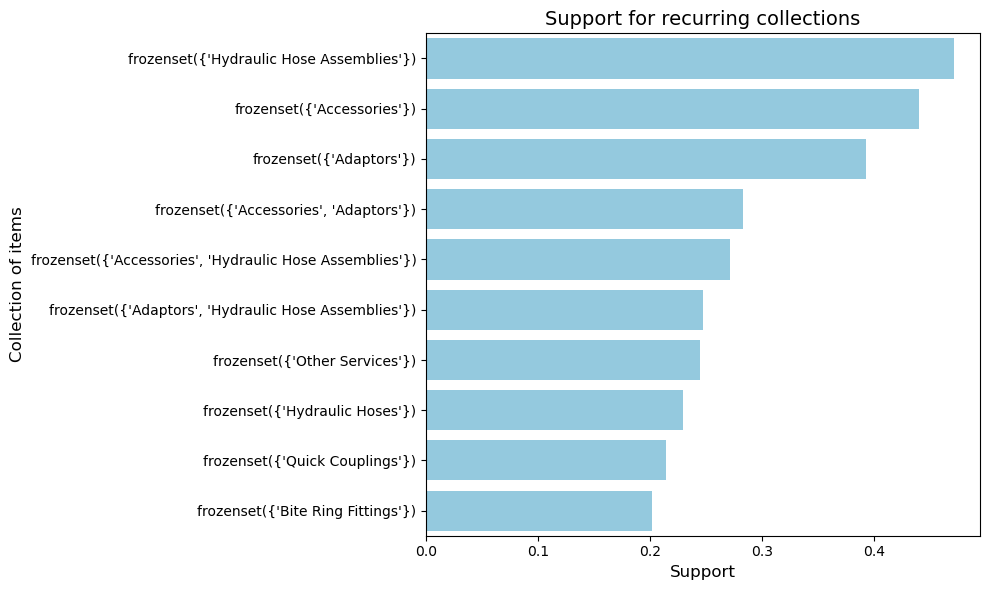

In [16]:
# Filter itemsets with high support
filtered_itemsets = frequent_itemsets[frequent_itemsets['support'] > 0.05]

# Show top 10 itemsets
top_itemsets = filtered_itemsets.nlargest(10, 'support')

# Optional: Shorten long itemsets
top_itemsets['itemsets'] = top_itemsets['itemsets'].apply(lambda x: x if len(x) <= 50 else x[:50] + '...')

# Plotting with horizontal bars
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_itemsets,
    x='support',
    y='itemsets',
    color='skyblue',
    orient='h'  # horizontal bars
)
plt.title('Support for recurring collections', fontsize=14)
plt.xlabel('Support', fontsize=12)
plt.ylabel('Collection of items', fontsize=12)
plt.tight_layout()
plt.show()


###  Visualization of Associations based on Lift and Confidence

C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categori

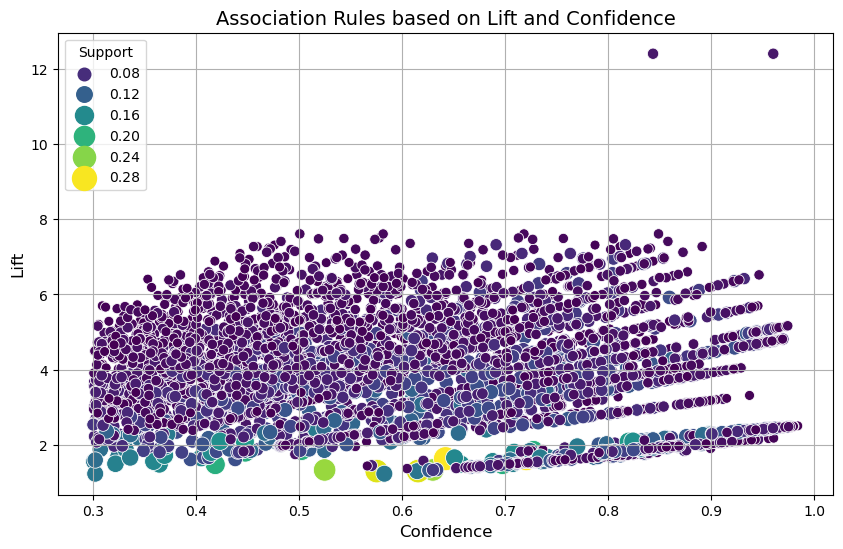

In [17]:


# Visualization of Associations based on Lift and Confidence
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rules,
    x='confidence',
    y='lift',
    size='support',
    hue='support',
    sizes=(50, 300),
    palette='viridis'
)

# Translate Persian text to English and remove reshaping
plt.title('Association Rules based on Lift and Confidence', fontsize=14)
plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Lift', fontsize=12)
plt.legend(title='Support', fontsize=10)
plt.grid(True)
plt.show()


C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categori

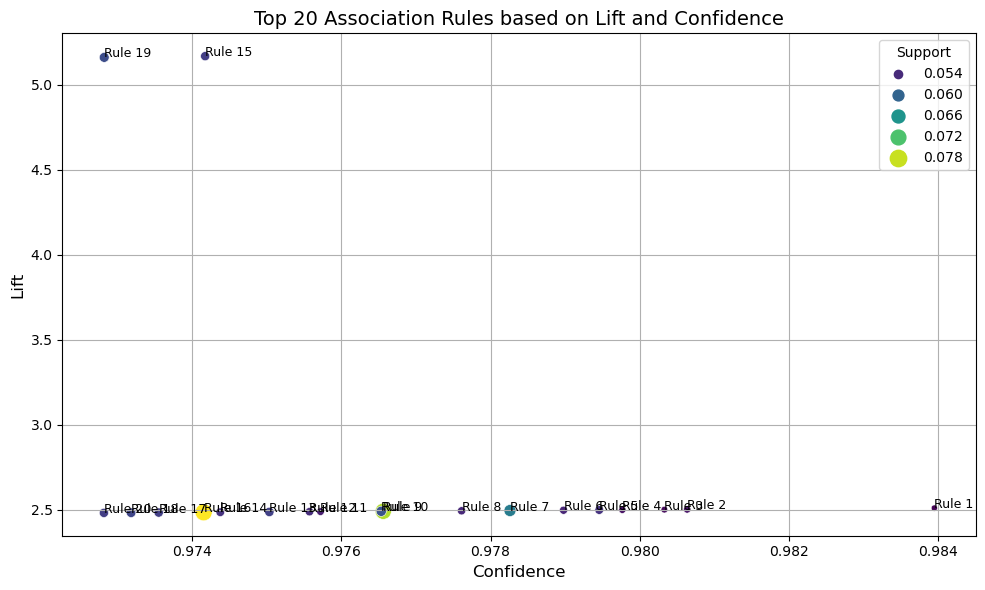

In [18]:
# Filter strong rules and show top 20
filtered_rules = rules[(rules['confidence'] > 0.5) & (rules['lift'] > 1)]
top_rules = filtered_rules.nlargest(20, 'confidence')

# Plot with adjusted sizes
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=top_rules,
    x='confidence',
    y='lift',
    size='support',
    hue='support',
    sizes=(20, 150),  # Smaller size range for clearer visualization
    palette='viridis'
)

# Title and labels
plt.title('Top 20 Association Rules based on Lift and Confidence', fontsize=14)
plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Lift', fontsize=12)
plt.legend(title='Support', fontsize=10)
plt.grid(True)

# Optional: Annotate the highest lift points
for i in range(len(top_rules)):
    plt.text(
        top_rules['confidence'].iloc[i],
        top_rules['lift'].iloc[i],
        f"Rule {i+1}",
        fontsize=9
    )

plt.tight_layout()
plt.show()


### Graph display for association rules

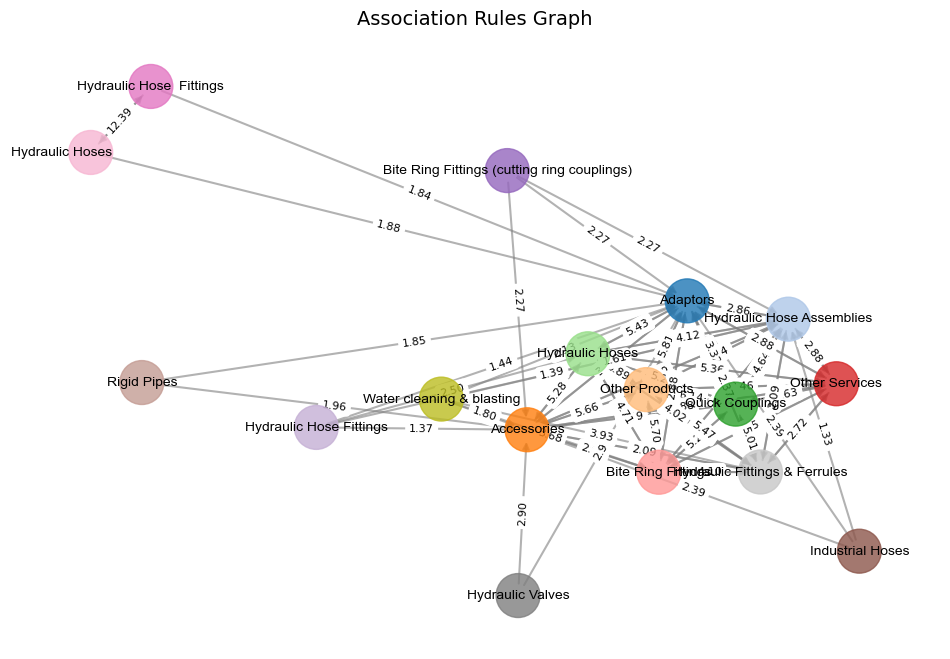

In [19]:


# Graph display for association rules
plt.figure(figsize=(12, 8))
G = nx.DiGraph()

# Adding nodes and edges
for _, rule in rules.iterrows():
    antecedents = list(rule['antecedents'])  # Convert frozenset to list
    consequents = list(rule['consequents'])  # Convert frozenset to list
    for antecedent in antecedents:
        for consequent in consequents:
            G.add_edge(antecedent, consequent, weight=rule['lift'])

# Graph settings
pos = nx.spring_layout(G, seed=42, k=0.9)  # Increase k for more node separation
color_map = plt.cm.tab20.colors  # Use preset colors
node_colors = [color_map[i % len(color_map)] for i in range(len(G.nodes()))]

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='Arial')

# Edge labels (lift value)
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Title and plot display
plt.title('Association Rules Graph', fontsize=14)
plt.axis('off')
plt.show()


#### Histogram plot for distribution of frequent itemsets support

C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\admin.nasim.FLCLAN\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


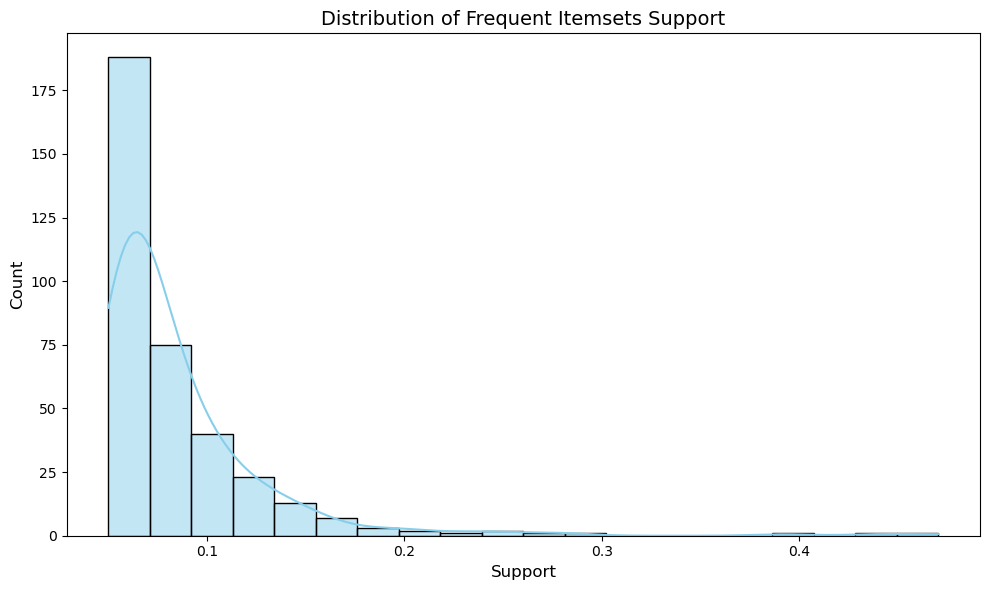

In [20]:

# Histogram plot for distribution of frequent itemsets support
plt.figure(figsize=(10, 6))
sns.histplot(frequent_itemsets['support'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Frequent Itemsets Support', fontsize=14)
plt.xlabel('Support', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()


#### Pie chart for displaying the number of products in association rules

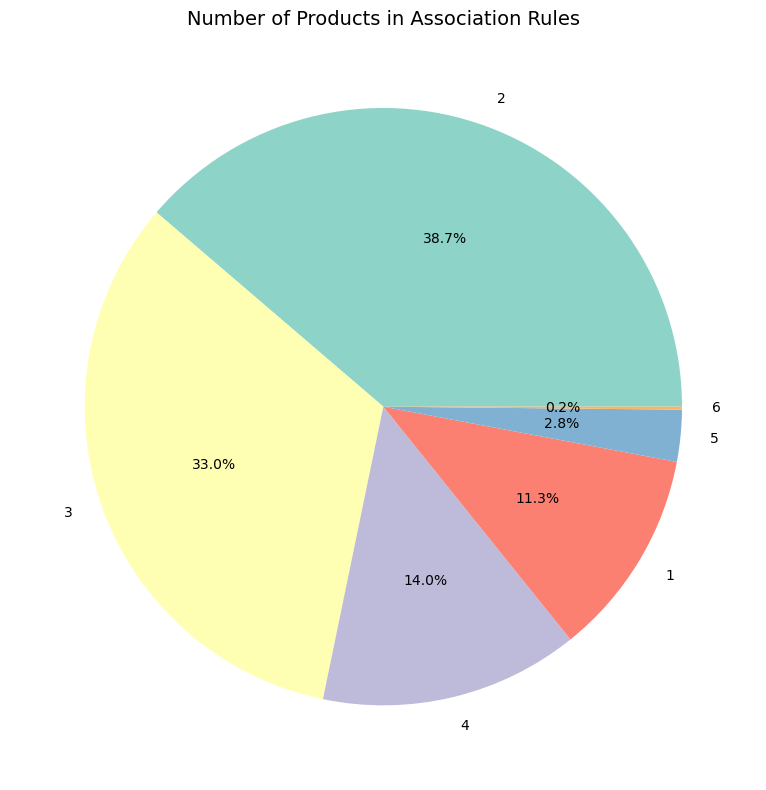

In [21]:
# Pie chart for displaying the number of products in association rules
product_counts = rules['antecedents'].apply(lambda x: len(list(x)))  # Convert frozenset to list
plt.figure(figsize=(8, 8))
product_counts.value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set3', n_colors=len(product_counts.unique())))
plt.title('Number of Products in Association Rules', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()


### Interpretation:

"Itemsets with higher support values represent more popular products, and customers are likely to have a greater inclination to purchase them. Itemsets with lower support values indicate that they appear less frequently in transactions, and they may be less popular or more specific."

Understand the Data:

	This table appears to contain association rules, typically generated using Market Basket Analysis. 
    Key columns include:
•	Antecedents: The products or sets of products that lead to certain outcomes.

•	Consequents: The products or sets of products that follow from the antecedents.

•   Support: The proportion of transactions that include both the antecedent and the consequent.

•	Confidence: The probability that a transaction containing the antecedent also contains the consequent.

•	Lift: How much more likely the consequent is given the antecedent, compared to if they were independent.

•	Other metrics such as leverage, conviction, certainty, etc., provide further insights into the association rule strength and reliability.


-----------------------------


  
  Create Calculations & Visualizations:

•	You can create measures to summarize important metrics such as support, confidence, lift, etc.

•	Create tables in Power BI to visualize the relationships between the antecedents and consequents.

•	Use scatter plots or bar charts to compare the lift and confidence values, showing the strength of associations between different product combinations.
  
    Filter for Specific Items:
    
•	Use slicers to allow filtering by specific antecedents or consequents.
    
•	Example: Filter by "Hydraulic Hose Assemblies" to see all associations where this product is involved.
    
  Highlight High Confidence/Lift Rules:
    
•	You can apply conditional formatting to tables to highlight association rules with higher confidence or lift values.
    
•	Example: Rules with a Lift > 1 suggest a stronger association than random chance, so you might want to focus on these rules.
    
  Analyze Trends:
    
•	Focus on metrics like lift and confidence to understand which product combinations are most frequently bought together.
    
•	Create visuals that show which products often appear together with high support or confidence.
    
